In [1]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 
              'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 
              'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 
              'sqft_lot':int, 'view':int}

In [2]:
import numpy as np
import pandas as pd

In [3]:
sales=pd.read_csv('kc_house_data.csv')
sales = sales.sort_values(['sqft_living','price'])

In [8]:
sales.head(2)
len(sales)

21613

#from Module 2, copy and paste the ‘get_numpy_data’ function (or equivalent) that takes
 (i) a dataframe, (ii) a list of features (e.g. [‘sqft_living’, ‘bedrooms’]), to be used as inputs, 
  (iii) a name of the output (e.g. ‘price’). 
  This function returns a ‘feature_matrix’ (2D array) consisting of first a column of ones followed by columns   containing the values of the input features in the data set in the same order as the input list. 
  It also return an ‘output_array’ which is an array of the values of the output in the data set (e.g. ‘price’).



In [5]:
def get_numpy_data(data_sframe,features,output):
    # add a constant column to an SFrame 
    data_sframe['constant'] =1 
    features = ['constant'] + features 
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe =data_sframe[features]
    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = features_sframe 
    
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray=data_sframe[output]
    # this will convert the SArray into a numpy array
    output_array = output_sarray 
    return(features_matrix,output_array)


#copy and paste the ‘predict_output’ function (or equivalent) from Module 2. This function accepts a 2D array ‘feature_matrix’ and a 1D array ‘weights’ and return a 1D array ‘predictions’.

In [6]:
def predict_output(feature_matrix,weights):
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

We are now going to move to computing the derivative of the regression cost function. 
Recall that the cost function is the sum over the data points of the squared difference between 
an observed output and a predicted output, plus the L2 penalty term.

Cost(w)= SUM[ (prediction - output)^2 ]+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).

The derivative of the RSS with respect to w[i] can be written as:
2*SUM[ error*[feature_i] ]
The derivative of the regularization term with respect to w[i] is:
2*l2_penalty*w[i]

Summing both 
2*SUM[ error*[feature_i] ] + 2*l2_penaltsy*w[i]

IMPORTANT: We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2*l2_penalty*w[0] term).


With this in mind write the derivative function which computes the derivative of the weight 
given the value of the feature (over all data points) and the errors (over all data points). 
To decide when to we are dealing with the constant (so we don't regularize it) 
we added the extra parameter to the call ‘feature_is_constant’ 
which you should set to True when computing the derivative of the constant and False otherwise.



In [9]:
def feature_derivative_ridge(errors,feature,weight,l2_penalty,feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if(feature_is_constant=='true'):
        derivative =2*np.dot(errors,feature)  
    else:
        derivative =2*np.dot(errors,feature) + 2*l2_penalty*weight
    return derivative

To test your feature derivartive run the following:

In [10]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
print(example_features.head(2),len(example_features))
print''
print(example_output.head(2))
# 19452 , 15381 are index of df 
print ''
print(example_features.shape)
print(example_features.iloc[:,1].shape)

(       constant  sqft_living
19452         1          290
15381         1          370, 21613)

19452    142000.0
15381    276000.0
Name: price, dtype: float64

(21613, 2)
(21613,)


In [11]:
my_weights = np.array([1., 10.])
print (my_weights)
test_predictions =predict_output(example_features,my_weights)
errors = test_predictions - example_output # prediction errors 
print("dimensions of test_predictions and example_output : " + str(test_predictions.ndim) ,str(example_output.ndim))
print(test_predictions , len(test_predictions))
print''
print(example_output.head(2),len(example_output))
print''
print(errors.head(2))

[  1.  10.]
('dimensions of test_predictions and example_output : 1', '1')
(array([   2901.,    3701.,    3801., ...,  100401.,  120501.,  135401.]), 21613)

(19452    142000.0
15381    276000.0
Name: price, dtype: float64, 21613)

19452   -139099.0
15381   -272299.0
Name: price, dtype: float64


In [12]:
# next two lines should print the same values
print feature_derivative_ridge(errors, example_features.iloc[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features.iloc[:,1])*2+20.
print ''
# iloc is used as example_features is pandas dataframe and select sqft living 

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features.iloc[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.


-5.6554166816e+13
-5.6554166816e+13

-22446749328.0
-22446749330.0


# Gradient Descent


Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [13]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                      step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while(iteration!=max_iterations):
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions =predict_output(feature_matrix,weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if(i==0):
                # feature_is_constant is passed as True 
                derivative =feature_derivative_ridge(errors, feature_matrix.iloc[:,i], weights[i], l2_penalty, True)
            else :
                derivative =feature_derivative_ridge(errors, feature_matrix.iloc[:,i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            weights[i]=weights[i]- (step_size*derivative)
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [16]:
simple_features = ['sqft_living']
my_output = 'price'

In [20]:
train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict)

In this part, we will only use 'sqft_living' to predict 'price'. Use the get_numpy_data function to get a Numpy versions of your data with only this feature, for both the train_data and the test_data.



In [21]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [24]:
print(simple_feature_matrix.shape , simple_feature_matrix.ndim)
print ''
print(output.shape, output.ndim)

((17384, 2), 2)

((17384,), 1)


In [25]:
#Let's set the parameters for our optimization:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

simple_weights_0_penalty

we'll use them later.

In [26]:
l2_penalty=0.0
simple_weights_0_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)


Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  5.39426721353e+15
Iteration = 3
Cost function =  4.02323773629e+15
Iteration = 4
Cost function =  3.1012561833e+15
Iteration = 5
Cost function =  2.4812476436e+15
Iteration = 6
Cost function =  2.0643080768e+15
Iteration = 7
Cost function =  1.78392709616e+15
Iteration = 8
Cost function =  1.59537820185e+15
Iteration = 9
Cost function =  1.4685839897e+15
Iteration = 10
Cost function =  1.38331819009e+15
Iteration = 20
Cost function =  1.21156213902e+15
Iteration = 30
Cost function =  1.20831376121e+15
Iteration = 40
Cost function =  1.20825232478e+15
Iteration = 50
Cost function =  1.20825116214e+15
Iteration = 60
Cost function =  1.20825113944e+15
Iteration = 70
Cost function =  1.2082511383e+15
Iteration = 80
Cost function =  1.20825113757e+15
Iteration = 90
Cost function =  1.20825113685e+15
Iteration = 100
Cost function =  1.20825113613e+15
Iteration = 200

In [27]:
l2_penalty = 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)


Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  5.61830389891e+15
Iteration = 3
Cost function =  4.92061332784e+15
Iteration = 4
Cost function =  4.65238205635e+15
Iteration = 5
Cost function =  4.54925894962e+15
Iteration = 6
Cost function =  4.50961265457e+15
Iteration = 7
Cost function =  4.49437039712e+15
Iteration = 8
Cost function =  4.4885104179e+15
Iteration = 9
Cost function =  4.48625751221e+15
Iteration = 10
Cost function =  4.48539136804e+15
Iteration = 20
Cost function =  4.48485042808e+15
Iteration = 30
Cost function =  4.48485039003e+15
Iteration = 40
Cost function =  4.48485039004e+15
Iteration = 50
Cost function =  4.48485039005e+15
Iteration = 60
Cost function =  4.48485039005e+15
Iteration = 70
Cost function =  4.48485039005e+15
Iteration = 80
Cost function =  4.48485039005e+15
Iteration = 90
Cost function =  4.48485039005e+15
Iteration = 100
Cost function =  4.48485039005e+15
Iteration

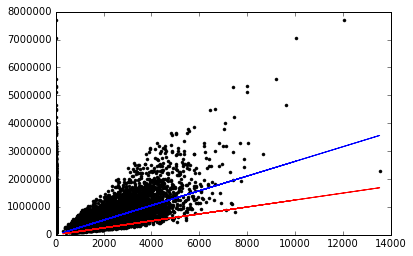

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [30]:
# 1. The initial weights (all zeros)

test_predictions =predict_output(simple_test_feature_matrix,initial_weights)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)


1.78427328614e+15


In [31]:
#2. The weights learned with no regularization

test_predictions =predict_output(simple_test_feature_matrix,simple_weights_0_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)


2.75723632154e+14


In [32]:
#3. The weights learned with high regularization
test_predictions =predict_output(simple_test_feature_matrix,simple_weights_high_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

6.94654309579e+14


In [33]:
# What is the value of the coefficient for sqft_living that you learned with no regularization, rounded to 1 decimal place?
# What about the one with high regularization?
simple_weights_0_penalty , simple_weights_high_penalty
# 1st value -1.63113515e-01 signify the w0 and 2nd value w1 i.e weight for sqft_living

(array([ -1.63113515e-01,   2.63024369e+02]),
 array([  4.87184758e-02,   1.24574021e+02]))

In [ ]:
#Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
# high reg
#What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?
#found above

# Running a multiple regression with L2 penalty¶

In [37]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [39]:
print(feature_matrix.shape , feature_matrix.ndim)
print ''
print(output.shape, output.ndim)

((17384, 3), 2)

((17384,), 1)


We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [40]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let’s consider no regularization. Set the L2 penalty to 0.0 and run your ridge regression algorithm. Use the following parameters:



In [42]:
l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)


Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  4.05675233205e+15
Iteration = 3
Cost function =  2.52956511453e+15
Iteration = 4
Cost function =  1.8385566943e+15
Iteration = 5
Cost function =  1.52567557515e+15
Iteration = 6
Cost function =  1.38378949857e+15
Iteration = 7
Cost function =  1.31923260615e+15
Iteration = 8
Cost function =  1.28964887188e+15
Iteration = 9
Cost function =  1.27588472391e+15
Iteration = 10
Cost function =  1.2692788074e+15
Iteration = 20
Cost function =  1.25781238602e+15
Iteration = 30
Cost function =  1.25195457086e+15
Iteration = 40
Cost function =  1.24675542266e+15
Iteration = 50
Cost function =  1.24213950817e+15
Iteration = 60
Cost function =  1.23804140048e+15
Iteration = 70
Cost function =  1.23440301274e+15
Iteration = 80
Cost function =  1.2311727742e+15
Iteration = 90
Cost function =  1.22830489923e+15
Iteration = 100
Cost function =  1.22575873839e+15
Iteration = 2

Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:

multiple_weights_high_penalty

In [43]:
l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                           step_size, l2_penalty, max_iterations)


Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185234e+15
Iteration = 2
Cost function =  4.46048979092e+15
Iteration = 3
Cost function =  3.79667450459e+15
Iteration = 4
Cost function =  3.64831960209e+15
Iteration = 5
Cost function =  3.61509121357e+15
Iteration = 6
Cost function =  3.60760289463e+15
Iteration = 7
Cost function =  3.60588651809e+15
Iteration = 8
Cost function =  3.60547511535e+15
Iteration = 9
Cost function =  3.60536545395e+15
Iteration = 10
Cost function =  3.60532973391e+15
Iteration = 20
Cost function =  3.60529506655e+15
Iteration = 30
Cost function =  3.60529477466e+15
Iteration = 40
Cost function =  3.60529477179e+15
Iteration = 50
Cost function =  3.60529477176e+15
Iteration = 60
Cost function =  3.60529477176e+15
Iteration = 70
Cost function =  3.60529477176e+15
Iteration = 80
Cost function =  3.60529477176e+15
Iteration = 90
Cost function =  3.60529477176e+15
Iteration = 100
Cost function =  3.60529477176e+15
Iteratio

In [44]:
# 1. The initial weights (all zeros)
test_predictions =predict_output(test_feature_matrix,initial_weights)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

1.78427328614e+15


In [45]:
#2.The weights learned with no regularization
test_predictions =predict_output(test_feature_matrix,multiple_weights_0_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

2.74067615919e+14


In [46]:
#3.The weights learned with high regularization

test_predictions =predict_output(test_feature_matrix,multiple_weights_high_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

5.00408530237e+14


In [47]:
# Which weights perform best?
# The weights learned with no regularization - 2.74067615919e+14

In [59]:
first_house=test_feature_matrix.iloc[0]

<bound method Series.sort of constant            1.0
sqft_living      1430.0
sqft_living15    1780.0
Name: 0, dtype: float64>

In [55]:
#Predict the house price for the 1st house in the test set using the no regularization 
# results may differ as the houses maynt be sorted 

test_predictions =predict_output(test_feature_matrix.iloc[0],multiple_weights_0_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

6.39483445052e+14


In [56]:
# Predict the house price for the 1st house in the test set using the high regularization 
test_predictions =predict_output(test_feature_matrix.iloc[0],multiple_weights_high_penalty)
errors = test_predictions - test_output # prediction errors 
print sum(errors*errors)

8.51378853403e+14


In [60]:
#Which weights perform best for the 1st house? 
# test set using the no regularization - 6.39483445052e+14 has less error 

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?